<a href="https://colab.research.google.com/github/CarlosMendez1997Sei/WETSAT_v2/blob/main/2_Modelling_WETSAT_Google_Colab/Wetsat_Geoprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

	Google Colaboratory
	PostgreSQL
	GitHub	     
	Wetlands flooding extent and trends using SATellite data and Machine Learning WETSAT
	Code Developed by
	Carlos Mendez
	Sebastian Palomino
	Camilo Sanabria                     

# Install packages and libraries used in WETSAT

In [1]:
###################################### Artificial Intelligence Frameworks #####################################################
# scikit-learn Framework
!pip install scikit-learn
###################################### Data, Geoprocessing and Graphics libraries #####################################################
!pip install rasterio
!pip install matplotlib
!pip install numpy
!pip install contextily
!pip install geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 42.3 MB/s eta 0:00:00


# Import libraries and packages

In [15]:
## AI packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

## Geoprocessing packages
import rasterio
from rasterio.features import rasterize
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import gc  # Garbage collector to free memory
import os
import contextily as ctx
from shapely.geometry import box
import seaborn as sns
import joblib
import urllib.request
import warnings
from google.colab import files
from google.colab import data_table

# Clone Repository from WETSAT [GitHub](https://github.com/sei-latam/WETSAT_v2)

In [3]:
!git clone https://github.com/sei-latam/WETSAT_v2.git

Cloning into 'WETSAT_v2'...
remote: Enumerating objects: 909, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 909 (delta 126), reused 55 (delta 51), pack-reused 699 (from 1)
Receiving objects: 100% (909/909), 3.21 GiB | 27.94 MiB/s, done.
Resolving deltas: 100% (203/203), done.
Updating files: 100% (320/320), done.


# Prepare data and first steps

## Import Sentinel-1 Raster Images (VH-VV) and create Polarization Ratio (PR) index

In [4]:
## Access the VH Path
vh_path = "/content/WETSAT_v2/0_Original_Files/aoi2/sigma_dB/VH"
## Access the VV Path
vv_path = "/content/WETSAT_v2/0_Original_Files/aoi2/sigma_dB/VV"
## Create the PR Index path
pr_path = "/content/WETSAT_v2/0_Original_Files/aoi2/sigma_dB/PR_index"

# Create output directory if it doesn't exist
os.makedirs(pr_path, exist_ok=True)

# List VH and VV files (assuming matching filenames)
vh_files = sorted([f for f in os.listdir(vh_path) if f.endswith(".tif")]) # Search files ending with .tif
vv_files = sorted([f for f in os.listdir(vv_path) if f.endswith(".tif")]) # Search files ending with .tif

# Loop through files and compute PR index scaled between 0 and 1
for vh_file, vv_file in zip(vh_files, vv_files):
    # Read the vh_files and vv_files
    with rasterio.open(os.path.join(vh_path, vh_file)) as vh_src, \
         rasterio.open(os.path.join(vv_path, vv_file)) as vv_src:

        vh = vh_src.read(1).astype("float32") # Converts the data to 32-bit float
        vv = vv_src.read(1).astype("float32") # Converts the data to 32-bit float

        pr_index_diff = vh - vv  # Compute PR index as difference

        # Save PR index difference
        profile = vh_src.profile
        profile.update(dtype="float32", count=1)

        pr_filename = f"PR_diff_{vh_file}"
        with rasterio.open(os.path.join(pr_path, pr_filename), "w", **profile) as dst:
            dst.write(pr_index_diff, 1)

print("PR index (VH - VV) computation complete.")

PR index (VH - VV) computation complete.


## Calculate General Statistics (minimum and maximum values)

In [ ]:
# @title
'''
def get_min_max_from_folder(folder_path): # Create a function to scan .tif images
    min_val = np.inf # initialize with the min values
    max_val = -np.inf # initialize with the max values

    for filename in sorted(os.listdir(folder_path)): # Begins a loop that iterates through all files in a folder
        if filename.endswith('.tif'):# Search files ending with .tif
            file_path = os.path.join(folder_path, filename) # Read the files using the path and filename
            with rasterio.open(file_path) as src: # Opens a raster file using rasterio
                data = src.read(1) #reads the first band of the raster file
                # Mask out no-data values if needed
                if src.nodata is not None: # Checks if the data include nodata values
                    data = np.ma.masked_equal(data, src.nodata) # Masks out all pixels without nodata
                min_val = min(min_val, data.min()) # Calculate and update the minimum values across all raster files
                max_val = max(max_val, data.max()) # Calculate and update the maximum values across all raster files

    return min_val, max_val #Return the min and max values

# Call the function and calculate min and max values in vh, vv and pr
vh_min, vh_max = get_min_max_from_folder(vh_path)
vv_min, vv_max = get_min_max_from_folder(vv_path)
pr_min, pr_max = get_min_max_from_folder(pr_path)

#Print the results
print(f"VH min: {vh_min}, VH max: {vh_max}")
print(f"VV min: {vv_min}, VV max: {vv_max}")
print(f"PR min: {pr_min}, PR max: {pr_max}")
'''

## Plot and visualize the Polarizaton Ratio (PR)

In [ ]:
# @title
'''
def visualize_images_grid_percentile(folder_path, title_prefix="PR Index"): # Create a function with (folder_path, title_prefix) as parameters
    tif_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.tif')]) # Search and scan in the path all raster images ending with .tif
    num_files = len(tif_files) # Calculate the number and total of files
    images_per_fig = 6 # Configure the number of images per figure

    for i in range(0, num_files, images_per_fig): # Initialize the looping
        fig, axes = plt.subplots(1, images_per_fig, figsize=(18, 3)) # Configure the subplots and size of images (18x3)
        axes = axes.flatten() # Specify that the axes are a flat 1D array

        for j in range(images_per_fig): #  loop that iterates over the number of images you want to display per figure:
            idx = i + j # Calculates the index of the current image file to be processed:
            if idx < num_files: # Verify the index is lower than number of files
                filename = tif_files[idx] # retrieves the filename at the current index from the sorted list of  files:
                with rasterio.open(os.path.join(folder_path, filename)) as src: # This line opens a raster file using its full path:
                    data = src.read(1) # This line reads the first band of the raster file
                    if src.nodata is not None: # Checks whether the raster file has a defined nodata value
                        data = np.ma.masked_equal(data, src.nodata) # smart way to handle missing or invalid data in raster files:

                    # Compute 2nd and 98th percentiles
                    p2 = np.nanpercentile(data, 2)
                    p98 = np.nanpercentile(data, 98)

                    # Clip data to percentile range
                    stretched = np.clip(data, p2, p98)

                    # Plot the images
                    im = axes[j].imshow(stretched, cmap='viridis', vmin=p2, vmax=p98)
                    axes[j].set_title(f"{filename}", fontsize=8) # Print the name of file
                    axes[j].axis('off')
                    fig.colorbar(im, ax=axes[j], shrink=1.0) # Adds a colorbar to the subplot displaying the raster image:
            else:
                axes[j].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.95]) # adjusts the layout of your figure to prevent overlapping elements:
        plt.show()
'''

In [ ]:
#visualize_images_grid_percentile(pr_path, title_prefix="PR Index")

## Plot and visualize the VH and VV images

In [ ]:
# @title
'''
def visualize_images_grid(folder_path, vmin, vmax, title_prefix): # Create a function with (folder_path, title_prefix) as parameters
    tif_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.tif')]) # Search and scan in the path all raster images ending with .tif
    num_files = len(tif_files) # Calculate the number and total of files
    images_per_fig = 6 # Configure the number of images per figure

    for i in range(0, num_files, images_per_fig): # Initialize the looping
        fig, axes = plt.subplots(1, 6, figsize=(18, 3)) # Configure the subplots and size of images (18x3)
        axes = axes.flatten() # Specify that the axes are a flat 1D array

        for j in range(images_per_fig): #  loop that iterates over the number of images you want to display per figure:
            idx = i + j # Calculates the index of the current image file to be processed:
            if idx < num_files: # Verify the index is lower than number of files
                filename = tif_files[idx] # retrieves the filename at the current index from the sorted list of  files:
                with rasterio.open(os.path.join(folder_path, filename)) as src: # This line opens a raster file using its full path:
                    data = src.read(1) # This line reads the first band of the raster file
                    if src.nodata is not None: # Checks whether the raster file has a defined nodata value
                        data = np.ma.masked_equal(data, src.nodata) # smart way to handle missing or invalid data in raster files:
                    im = axes[j].imshow(data, cmap='viridis', vmin=vmin, vmax=vmax)
                    axes[j].set_title(filename, fontsize=10)  # Print the name of file
                    axes[j].axis('off')
                    fig.colorbar(im, ax=axes[j], shrink=1.0) # Adds a colorbar to the subplot displaying the raster image:
            else:
                axes[j].axis('off')  # Hide unused subplot

        plt.tight_layout(rect=[0, 0, 1, 0.95]) # adjusts the layout of your figure to prevent overlapping elements:
        plt.show()
'''

In [ ]:
# @title
'''
# Visualize each image with consistent scaling
visualize_images_grid(vh_path, vh_min, vh_max, "VH")
'''

In [ ]:
# @title
'''
# Visualize each image with consistent scaling
visualize_images_grid(vv_path, vv_min, vv_max, "VV")
'''

In [ ]:
# @title
'''
# Visualize each image with consistent scaling
visualize_images_grid(pr_path, pr_min, pr_max, "PR")
'''

## Combine VH-VV-PR data

In [5]:
# Create a function to load images in a folder
def load_images(folder_path): # Create a request 'folder path' as a directory of data
    images = [] # Create a temporal empty array of images
    for file in sorted(os.listdir(folder_path)): # Call the folfer 'path'
        if file.endswith(".tif"): # Search images ending in .tif
            with rasterio.open(os.path.join(folder_path, file)) as src: # Open the images located in folder path
                images.append(src.read(1))
    return np.array(images) # Return array of images

# Call function and load images
vh_images = load_images(vh_path)
vv_images = load_images(vv_path)
pr_images = load_images(pr_path)

print(f"System recognized {vh_images.shape[0]} images VH polarization with size {vh_images.shape[1:]} each one.")
print(f"System recognized {vv_images.shape[0]} images VV polarization with size {vv_images.shape[1:]} each one.")
print(f"System recognized {pr_images.shape[0]} images of PR Index with size {pr_images.shape[1:]} each one.")

assert vh_images.shape == vv_images.shape == pr_images.shape, "The dimensions and size of VH-VV-PR are equal"

# Combine the VH-VV-PR polarization with the same size and dimensions
master_data = np.stack([vh_images, vv_images, pr_images], axis=-1)  # (n_images)

print(f"System combine the VH-VV-PR polarizations wit the size {master_data.shape}")

System recognized 24 images VH polarization with size (3875, 2804) each one.
System recognized 24 images VV polarization with size (3875, 2804) each one.
System recognized 24 images of PR Index with size (3875, 2804) each one.
System combine the VH-VV-PR polarizations wit the size (24, 3875, 2804, 3)


# Import points (.shp) with labels and marks

In [57]:
# Load shapefile
shapefile_path = "/content/WETSAT_v2/0_Original_Files/aoi2/points_AOI2_BDE.shp"
gdf = gpd.read_file(shapefile_path)

# Verificar valores únicos por columna que podrían contener etiquetas
print("\nValores únicos por columna (solo columnas tipo 'object'):")
for col in gdf.columns:
    if gdf[col].dtype == 'object':
        print(f"\nColumna: {col}")
        print(gdf[col].unique())


Valores únicos por columna (solo columnas tipo 'object'):

Columna: Station
['3A11' '3A12' '3AN1W1' '3AS' '3AS3W1' '3ASW' 'BCA10' 'BCA12' 'BCA13'
 'BCA18' 'BCA20' 'BCA4' 'BCA5' 'BCA9' 'EDEN_10' 'EDEN_12' 'EDEN_14'
 'EDEN_5' 'EDEN_6' 'EDEN_8' 'EDEN_9' 'L28_GAP' 'NP201' 'NP202' 'NP203'
 'NP205' 'NP206' 'OT' 'P33' 'P34' 'RG1' 'RG2' 'TI-9' 'TMC' 'W11' 'W18'
 'W2' 'MO-214' 'NESRS1' 'NESRS4' 'SITE_62' 'SITE_64' 'SITE_65']

Columna: 1_01_2024_
['e11' 'e21' 'e22' 'e23']

Columna: 1_13_2024_
['e11' 'e21' 'e22' 'e23']

Columna: 1_25_2024_
['e11' 'e21' 'e22' 'e23']

Columna: 2_06_2024_
['e11' 'e21' 'e22' 'e23']

Columna: 2_18_2024_
['e21' 'e22' 'e13' 'e23' 'e11']

Columna: 3_01_2024_
['e21' 'e22' 'e13' 'e23' 'e11']

Columna: 3_13_2024_
['e21' 'e22' 'e13' 'e23' 'e11' 'e12']

Columna: 3_25_2024_
['e21' 'e22' 'e11' 'e13' 'e23' 'e12']

Columna: 4_06_2024_
['e11' 'e21' 'e22' 'e13' 'e23' 'e12']

Columna: 4_18_2024_
['e11' 'e21' 'e22' 'e13' 'e23' 'e12']

Columna: 4_30_2024_
['e11' 'e21' 'e22' 'e13' 'e1

In [ ]:
# @title
'''
#providers = ctx.providers
#providers

# Plot the .shp
ax = gdf.plot(figsize=(10, 10))
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Esri.WorldImagery)
plt.title('Shapefile Points')
plt.show()
'''

## Verification shapefile information (rows and fields)

In [ ]:
# @title
'''
# Show all rows and fields
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Display Geodataframe as table
display(gdf)
'''

## Verify Coordinate Reference System (CRS)

In [7]:
# Open a reference raster to get CRS and bounds
with rasterio.open(os.path.join(vh_path, vh_files[0])) as src:
    gdf = gdf.to_crs(src.crs) # Reproject shapefile to match raster CRS
    transform = src.transform

raster_crs = src.crs
print("The Coordinate Reference System (CRS) is:", raster_crs)

raster_bounds = box(*src.bounds)

print("Bounds image:", src.bounds)
print("Bounds shapefile:", gdf.total_bounds)

# Filter points that fall within the raster extent
gdf_filtered = gdf[gdf.geometry.within(raster_bounds)]
print(f"Points inside raster: {len(gdf_filtered)} of {len(gdf)}")

# Extract the coordinates (x, y) in each point
coords = [(geom.x, geom.y) for geom in gdf.geometry]

The Coordinate Reference System (CRS) is: EPSG:32617
Bounds image: BoundingBox(left=488300.0, bottom=2823700.0, right=544380.0, top=2901200.0)
Bounds shapefile: [ 489599.51383088 2825091.04763268  541222.74691443 2900327.16197831]
Points inside raster: 43 of 43


In [52]:
def extract_pixel_values(image_array, transform, points_gdf):
    rows, cols = rasterio.transform.rowcol(transform, points_gdf.geometry.x, points_gdf.geometry.y)
    values = []
    for r, c in zip(rows, cols):
        try:
            values.append(image_array[r, c])
        except IndexError:
            values.append(np.nan)
    return values

with rasterio.open(os.path.join(vh_path, vh_files[0])) as src:
    transform = src.transform

etiqueta_cols = [col for col in gdf.columns if col not in ['Station', 'geometry']]
assert len(etiqueta_cols) == master_data.shape[0], "Las columnas de etiquetas deben coincidir con el número de imágenes"

resultados = []

for i, col in enumerate(etiqueta_cols):
    vh_img = master_data[i, :, :, 0]
    vv_img = master_data[i, :, :, 1]
    pr_img = master_data[i, :, :, 2]

    etiquetas = gdf[col]

    vh_vals = extract_pixel_values(vh_img, transform, gdf)
    vv_vals = extract_pixel_values(vv_img, transform, gdf)
    pr_vals = extract_pixel_values(pr_img, transform, gdf)

    df = pd.DataFrame({
        'VH': vh_vals,
        'VV': vv_vals,
        'PR': pr_vals,
        'etiqueta': etiquetas,
        'imagen': col
    })

    resultados.append(df)

In [54]:
df_final = pd.concat(resultados, ignore_index=True)
data_table.DataTable(df_final, include_index=False, num_rows_per_page=100)

,VH,VV,PR,etiqueta,imagen
0,-22.825550,-7.347487,-15.478063,e11,1_01_2024_
1,-17.096886,-5.754534,-11.342352,e21,1_01_2024_
2,-22.578693,-8.405565,-14.173128,e21,1_01_2024_
3,-15.478000,-9.186302,-6.291698,e22,1_01_2024_
4,-15.520418,-6.393513,-9.126905,e21,1_01_2024_
5,-14.316200,-6.564840,-7.751360,e21,1_01_2024_
6,-13.446002,-5.001499,-8.444503,e23,1_01_2024_
7,-12.553789,-6.720149,-5.833640,e23,1_01_2024_
8,-13.728954,-6.007545,-7.721409,e23,1_01_2024_
9,-12.018113,-7.887706,-4.130407,e21,1_01_2024_


In [55]:
# Contar observaciones por etiqueta
conteo_etiquetas = df_final['etiqueta'].value_counts().sort_index()

# Mostrar resultados
print("Cantidad de observaciones por etiqueta:")
print(conteo_etiquetas)

Cantidad de observaciones por etiqueta:
etiqueta
e11    129
e12      8
e13     33
e21    567
e22    208
e23     87
Name: count, dtype: int64


In [63]:
etiquetas_validas = ['e21', 'e12', 'e13', 'e22', 'e23']
df_modelo = df_final.dropna(subset=['VV', 'VH', 'PR', 'etiqueta'])

le = LabelEncoder()
df_modelo['etiqueta_cod'] = le.fit_transform(df_modelo['etiqueta'])

X = df_modelo[['VV', 'VH', 'PR']].values
y = df_modelo['etiqueta_cod'].values

mask_validacion = df_modelo['etiqueta'].isin(etiquetas_validas)
X_train = X[~mask_validacion]
y_train = y[~mask_validacion]
X_val = X[mask_validacion]
y_val = y[mask_validacion]

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

print("Reporte de clasificación:")
print(classification_report(y_val, y_pred, target_names=le.classes_))

Reporte de clasificación:
              precision    recall  f1-score   support

         e11       0.00      0.00      0.00       0.0
         e12       0.00      0.00      0.00       8.0
         e13       0.00      0.00      0.00      33.0
         e21       0.00      0.00      0.00     567.0
         e22       0.00      0.00      0.00     208.0
         e23       0.00      0.00      0.00      87.0

    accuracy                           0.00     903.0
   macro avg       0.00      0.00      0.00     903.0
weighted avg       0.00      0.00      0.00     903.0



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

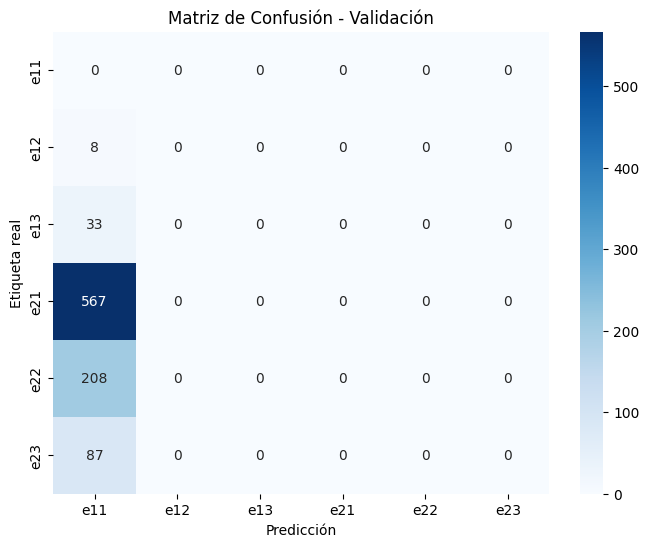

In [64]:
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title('Matriz de Confusión - Validación')
plt.show()

In [66]:
## Access the VH Path
vh_path = "/content/WETSAT_v2/0_Original_Files/aoi1/aoi1/sigma_dB/VH_sigma_dB"
## Access the VV Path
vv_path = "/content/WETSAT_v2/0_Original_Files/aoi1/aoi1/sigma_dB/VV_sigma_dB"
## Create the PR Index path
pr_path = "/content/WETSAT_v2/0_Original_Files/aoi1/aoi1/sigma_dB/PR_index"

# Create output directory if it doesn't exist
os.makedirs(pr_path, exist_ok=True)

# List VH and VV files (assuming matching filenames)
vh_files = sorted([f for f in os.listdir(vh_path) if f.endswith(".tif")]) # Search files ending with .tif
vv_files = sorted([f for f in os.listdir(vv_path) if f.endswith(".tif")]) # Search files ending with .tif

# Loop through files and compute PR index scaled between 0 and 1
for vh_file, vv_file in zip(vh_files, vv_files):
    # Read the vh_files and vv_files
    with rasterio.open(os.path.join(vh_path, vh_file)) as vh_src, \
         rasterio.open(os.path.join(vv_path, vv_file)) as vv_src:

        vh = vh_src.read(1).astype("float32") # Converts the data to 32-bit float
        vv = vv_src.read(1).astype("float32") # Converts the data to 32-bit float

        pr_index_diff = vh - vv  # Compute PR index as difference

        # Save PR index difference
        profile = vh_src.profile
        profile.update(dtype="float32", count=1)

        pr_filename = f"PR_diff_{vh_file}"
        with rasterio.open(os.path.join(pr_path, pr_filename), "w", **profile) as dst:
            dst.write(pr_index_diff, 1)

print("PR index (VH - VV) computation complete.")

PR index (VH - VV) computation complete.


In [65]:
def load_images(folder_path):
    images = []
    files = sorted([f for f in os.listdir(folder_path) if f.endswith(".tif")])
    for file in files:
        with rasterio.open(os.path.join(folder_path, file)) as src:
            images.append(src.read(1))
    return np.array(images), files

In [67]:
## Access the VH Path
vh_path = "/content/WETSAT_v2/0_Original_Files/aoi1/aoi1/sigma_dB/VH_sigma_dB"
## Access the VV Path
vv_path = "/content/WETSAT_v2/0_Original_Files/aoi1/aoi1/sigma_dB/VV_sigma_dB"
## Create the PR Index path
pr_path = "/content/WETSAT_v2/0_Original_Files/aoi1/aoi1/sigma_dB/PR_index"

# Cargar imágenes
vv_images, vv_files = load_images(vv_path)
vh_images, vh_files = load_images(vh_path)
pr_images, pr_files = load_images(pr_path)

assert vv_images.shape == vh_images.shape == pr_images.shape, "Las dimensiones de VV, VH y PR deben coincidir"

In [68]:
with rasterio.open(os.path.join(vv_path, vv_files[0])) as src:
    profile = src.profile
    transform = src.transform

In [69]:
# Crear carpeta de salida
output_dir = "/content/predicted_rasters"
os.makedirs(output_dir, exist_ok=True)

# Iterar sobre cada trío de imágenes
for i in range(vv_images.shape[0]):
    vv_img = vv_images[i]
    vh_img = vh_images[i]
    pr_img = pr_images[i]

    # Stack y reshape
    stacked = np.stack([vv_img, vh_img, pr_img], axis=-1)
    X_new = stacked.reshape(-1, 3)

    # Predicción
    y_pred_new = rf.predict(X_new)
    predicted_map = y_pred_new.reshape(vv_img.shape)

    # Guardar imagen raster
    profile.update(dtype=rasterio.uint8, count=1)
    output_path = os.path.join(output_dir, f"predicted_labels_{i+1:02d}.tif")

    with rasterio.open(output_path, "w", **profile) as dst:
        dst.write(predicted_map.astype(rasterio.uint8), 1)

print(f"✅ Se generaron {vv_images.shape[0]} imágenes de etiquetas en: {output_dir}")

ValueError: Given nodata value, -3.4028234663852886e+38, is beyond the valid range of its data type, uint8.

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(predicted_map, cmap='tab10')
plt.title(f"Mapa de etiquetas - Imagen {i+1:02d}")
plt.colorbar(label="Etiqueta codificada")
plt.axis('off')
plt.show()

In [ ]:
# @title
'''
# Create a DataFrame with the coordinates X (longitud) and Y (latitud)
coords_df = pd.DataFrame(coords, columns=['X', 'Y'])
# Display all rows
pd.set_option('display.max_rows', None)
# Display all dataframe
print(coords_df)
'''

## Calculate only pixels inside coordinate points(.shp)

In [ ]:
## Calculate only pixels inside coordinate points(.shp)
def extract_pixel_values(images, transform, coords): # Create a funcion that requires three parameters (images_path, transform labels, and coordinates)
    from rasterio.transform import rowcol
    values = [] # Create an empty array
    for img in images: # Loop and iteration with the images size
        img_vals = []
        for x, y in coords: # Call coordinates
            row, col = rowcol(transform, x, y)
            try:
                val = img[row, col]
            except IndexError:
                val = np.nan
            img_vals.append(val)
        values.append(img_vals)
    return np.array(values).T  # shape: (n_points, n_images)

vh_values = extract_pixel_values(vh_images, transform, coords)
vv_values = extract_pixel_values(vv_images, transform, coords)
pr_values = extract_pixel_values(pr_images, transform, coords)

In [ ]:
# Función para calcular estadísticas por punto
def compute_stats(values):
    return np.column_stack([
        np.nanmean(values, axis=1),
        np.nanstd(values, axis=1),
        np.nanmin(values, axis=1),
        np.nanmax(values, axis=1),
        np.nanpercentile(values, 25, axis=1),
        np.nanpercentile(values, 50, axis=1),
        np.nanpercentile(values, 75, axis=1)
    ])

# Calcular estadísticas por punto para cada banda
vh_stats = compute_stats(vh_values)
vv_stats = compute_stats(vv_values)
pr_stats = compute_stats(pr_values)

In [ ]:
# Crear matriz de entrada con estadísticas agregadas
X = np.hstack([vh_stats, vv_stats, pr_stats])

# Create Matrix with the Labels and Data

In [ ]:
label_columns = [
    '1_01_2024_', '1_13_2024_', '1_25_2024_', '2_06_2024_', '2_18_2024_', '3_01_2024_',
    '3_13_2024_', '3_25_2024_', '4_06_2024_', '4_18_2024_', '4_30_2024_', '5_12_2024_',
    '6_29_2024_', '8_04_2024_', '8_16_2024_', '8_28_2024_', '9_09_2024_', '9_21_2024_',
    '10_03_2024', '10_15_2024', '10_27_2024', '11_08_2024', '12_14_2024', '12_26_2024'
]

y = gdf[label_columns].copy()

matrix = y # Matriz create a copy(y) to display

encoders = {}
## Transform labels (string to integer)
for col in label_columns:
    if y[col].dtype == 'object':
        le = LabelEncoder()
        y[col] = le.fit_transform(y[col].astype(str))
        encoders[col] = le

y = y.values

encoders_labels = encoders # encoders_labels create a copy of encoders to display
y_labels = y.shape

joblib.dump(X, "X_matrix.pkl")
joblib.dump(y, "y_matrix.pkl")
joblib.dump(encoders, "encoders.pkl")

['encoders.pkl']

### Verification of X matrix (training)

In [ ]:
# @title
# Create DataFrames with the original fields
vh_df = pd.DataFrame(vh_values, columns=[f'VH_{i+1}' for i in range(vh_values.shape[1])])
vv_df = pd.DataFrame(vv_values, columns=[f'VV_{i+1}' for i in range(vv_values.shape[1])])
pr_df = pd.DataFrame(pr_values, columns=[f'PR_{i+1}' for i in range(pr_values.shape[1])])

pd.set_option('display.max_columns', None)

print(vh_df)
print(vv_df)
print(pr_df)

         VH_1       VH_2       VH_3       VH_4       VH_5       VH_6       VH_7       VH_8       VH_9      VH_10      VH_11      VH_12      VH_13      VH_14      VH_15      VH_16      VH_17      VH_18      VH_19      VH_20      VH_21      VH_22      VH_23      VH_24
0  -22.825550 -19.003923 -23.548166 -15.410807 -17.296377 -16.547377 -17.105921 -20.139074 -17.150877 -16.989248 -12.223232 -14.573515 -22.249680 -19.323900 -17.966095 -14.666943 -17.152493 -26.174803 -22.030134 -20.261169 -14.484188 -14.747114 -14.553804 -18.135025
1  -17.096886 -17.609341 -18.489590 -16.642359 -15.288650 -15.638208 -13.945312 -15.858240 -14.966642 -13.778534 -13.779379 -16.261726 -17.633553 -16.134499 -18.063038 -16.295006 -14.144326 -19.170683 -20.612240 -18.493172 -19.479933 -16.461956 -16.134167 -16.479506
2  -22.578693 -21.874481 -23.268379 -16.705824 -16.725754 -16.287386 -18.419703 -20.416716 -16.215073 -16.514542 -14.649857 -13.598466 -19.064123 -19.279484 -19.162758 -16.639414 -18.337061 -29.74880

In [ ]:
# Crear DataFrames con nombres descriptivos para cada estadística
stat_names = ['mean', 'std', 'min', 'max', 'p25', 'p50', 'p75']
vh_stats_df = pd.DataFrame(vh_stats, columns=[f'VH_{name}' for name in stat_names])
vv_stats_df = pd.DataFrame(vv_stats, columns=[f'VV_{name}' for name in stat_names])
pr_stats_df = pd.DataFrame(pr_stats, columns=[f'PR_{name}' for name in stat_names])

# Mostrar todas las columnas sin truncar
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Imprimir el DataFrame combinado
print(vh_stats_df)
print(vv_stats_df)
print(pr_stats_df)

      VH_mean    VH_std     VH_min     VH_max     VH_p25     VH_p50     VH_p75
0  -18.106642  3.360318 -26.174803 -12.223232 -20.169598 -17.224434 -15.244884
1  -16.602369  1.804657 -20.612240 -13.778534 -17.740925 -16.378481 -15.550818
2  -18.762215  3.673616 -29.748806 -13.598466 -20.500017 -18.372673 -16.457752
3  -15.682434  2.267969 -23.556770 -12.474080 -16.246162 -15.429401 -14.186042
4  -16.414103  1.591233 -19.114281 -13.746662 -17.784010 -16.159119 -15.421224
5  -14.061981  1.359337 -16.828243 -12.137176 -15.161049 -13.720947 -12.805973
6  -12.823888  0.887691 -14.429586 -11.196196 -13.460305 -12.711311 -12.294024
7  -12.567593  1.217925 -15.173279  -9.831832 -13.345377 -12.455824 -11.852830
8  -13.833491  0.743575 -15.254617 -12.623432 -14.375693 -13.692062 -13.271219
9  -13.029473  1.000459 -14.708892 -11.346034 -13.936272 -12.980368 -12.543510
10 -14.594280  0.680551 -15.858995 -13.592451 -14.993412 -14.595440 -14.100288
11 -14.763461  1.238914 -16.986488 -12.856277 -15.81

### Verification of encoders by row with dictionary of labels

In [ ]:
# Display all encoders by field
for col, encoder in encoders.items():
    print(f"\nEtiqueta: {col}")
    print(dict(zip(encoder.classes_, encoder.transform(encoder.classes_))))


Etiqueta: 1_01_2024_
{'e11': np.int64(0), 'e21': np.int64(1), 'e22': np.int64(2), 'e23': np.int64(3)}

Etiqueta: 1_13_2024_
{'e11': np.int64(0), 'e21': np.int64(1), 'e22': np.int64(2), 'e23': np.int64(3)}

Etiqueta: 1_25_2024_
{'e11': np.int64(0), 'e21': np.int64(1), 'e22': np.int64(2), 'e23': np.int64(3)}

Etiqueta: 2_06_2024_
{'e11': np.int64(0), 'e21': np.int64(1), 'e22': np.int64(2), 'e23': np.int64(3)}

Etiqueta: 2_18_2024_
{'e11': np.int64(0), 'e13': np.int64(1), 'e21': np.int64(2), 'e22': np.int64(3), 'e23': np.int64(4)}

Etiqueta: 3_01_2024_
{'e11': np.int64(0), 'e13': np.int64(1), 'e21': np.int64(2), 'e22': np.int64(3), 'e23': np.int64(4)}

Etiqueta: 3_13_2024_
{'e11': np.int64(0), 'e12': np.int64(1), 'e13': np.int64(2), 'e21': np.int64(3), 'e22': np.int64(4), 'e23': np.int64(5)}

Etiqueta: 3_25_2024_
{'e11': np.int64(0), 'e12': np.int64(1), 'e13': np.int64(2), 'e21': np.int64(3), 'e22': np.int64(4), 'e23': np.int64(5)}

Etiqueta: 4_06_2024_
{'e11': np.int64(0), 'e12': np.int

### Verification of y Matrix (validation)

In [ ]:
# Convert the original dataframe with strings into integers
y_df = pd.DataFrame(y, columns=label_columns)

# Display dataframe with size
print(f"Shape of y_df: {y_df.shape}")
display(y_df)

Shape of y_df: (43, 24)


,1_01_2024_,1_13_2024_,1_25_2024_,2_06_2024_,2_18_2024_,3_01_2024_,3_13_2024_,3_25_2024_,4_06_2024_,4_18_2024_,4_30_2024_,5_12_2024_,6_29_2024_,8_04_2024_,8_16_2024_,8_28_2024_,9_09_2024_,9_21_2024_,10_03_2024,10_15_2024,10_27_2024,11_08_2024,12_14_2024,12_26_2024
0,0,0,0,0,2,2,3,3,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
1,1,1,1,1,2,2,3,3,3,3,3,3,2,2,2,1,1,0,0,0,0,1,0,0
2,1,1,1,1,2,2,3,3,3,3,3,3,2,2,2,1,1,0,0,0,0,1,0,0
3,2,2,2,2,3,3,4,4,4,4,4,4,3,3,3,2,2,1,1,1,1,2,1,1
4,1,1,1,1,2,2,3,3,3,3,3,3,2,2,2,1,1,0,0,0,0,1,0,0
5,1,1,1,1,2,2,3,0,0,0,0,0,2,2,2,1,1,0,0,0,0,1,0,0
6,3,3,3,3,1,1,2,2,2,2,2,2,4,4,4,3,3,2,2,2,2,3,2,2
7,3,3,3,3,4,4,5,5,5,2,2,2,1,1,1,3,3,2,2,2,2,3,2,2
8,3,3,3,3,4,4,5,2,2,2,2,2,1,4,4,3,3,2,2,2,2,3,2,2
9,1,1,1,1,2,2,3,3,0,0,0,0,0,2,2,1,1,0,0,0,0,1,0,0


# Create Random Forest Classifier Model

### Configure best Hyperparameters


- n_estimators: Number of trees in the forest. The larger the better, but also the longer it will take to compute
- max_depth: Maximum depth of each tree.
- min_samples_split: Minimum samples required to split an internal node.
- min_samples_leaf: Minimum samples required at a leaf node.
- max_features: Size of the random subsets of features to consider when splitting a node. The lower the greater the reduction of variance, but also the greater the increase in bias.

In [ ]:
# Ignore possible warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Create folder where the .pkl models will be stored
os.makedirs("models", exist_ok=True)

# Define and set Hyperparameters
param_grid = {
    'estimator__n_estimators': [100, 200],
    'estimator__max_depth': [10, 20, None],
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [1, 2],
    'estimator__max_features': ['sqrt', 'log2']
}

## Start RF model with (70% training) and (30% validation)

In [ ]:
# Definir modelo base
base_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
multi_rf = MultiOutputClassifier(base_rf)

# Búsqueda de hiperparámetros
grid_search = GridSearchCV(multi_rf, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X, y)

# Predicciones sobre el conjunto de entrenamiento
y_pred = grid_search.predict(X)

# Reporte general por etiqueta
for i, col in enumerate(label_columns):
    print(f"\n🔎 Métricas para la etiqueta: {col}")
    print("Accuracy:", accuracy_score(y[:, i], y_pred[:, i]))
    print("Matriz de confusión:")
    print(confusion_matrix(y[:, i], y_pred[:, i]))
    print("Reporte de clasificación:")
    print(classification_report(y[:, i], y_pred[:, i]))

# Guardar modelo entrenado
joblib.dump(grid_search.best_estimator_, "models/random_forest_model.pkl")
print("Modelo entrenado y guardado exitosamente.")

Fitting 3 folds for each of 48 candidates, totalling 144 fits

🔎 Métricas para la etiqueta: 1_01_2024_
Accuracy: 0.9069767441860465
Matriz de confusión:
[[ 0  2  0  0]
 [ 0 27  0  0]
 [ 0  1  7  1]
 [ 0  0  0  5]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.90      1.00      0.95        27
           2       1.00      0.78      0.88         9
           3       0.83      1.00      0.91         5

    accuracy                           0.91        43
   macro avg       0.68      0.69      0.68        43
weighted avg       0.87      0.91      0.88        43


🔎 Métricas para la etiqueta: 1_13_2024_
Accuracy: 0.9302325581395349
Matriz de confusión:
[[ 3  1  0  0]
 [ 0 25  0  0]
 [ 0  1  7  1]
 [ 0  0  0  5]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.93      1.00     

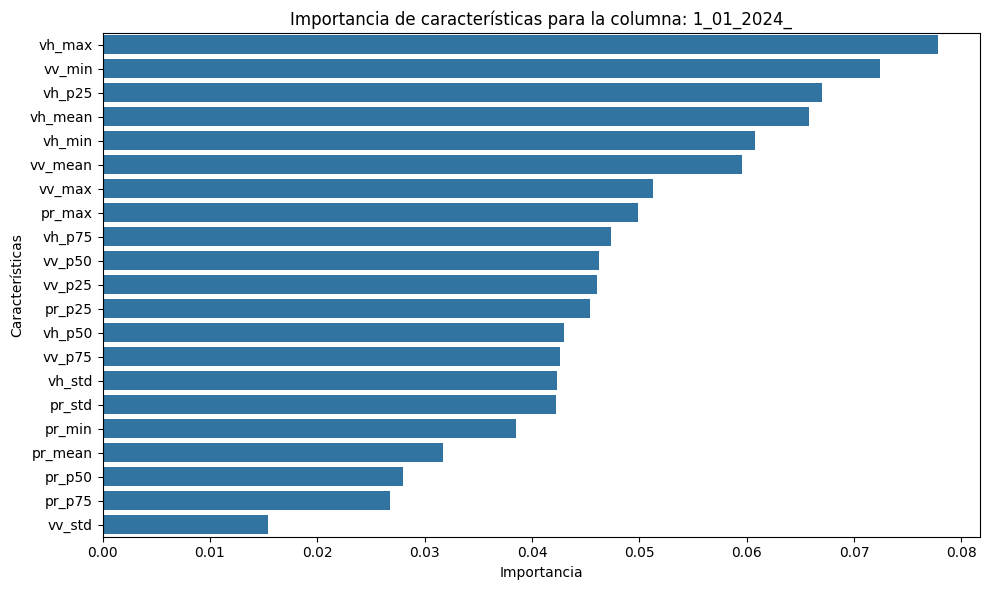

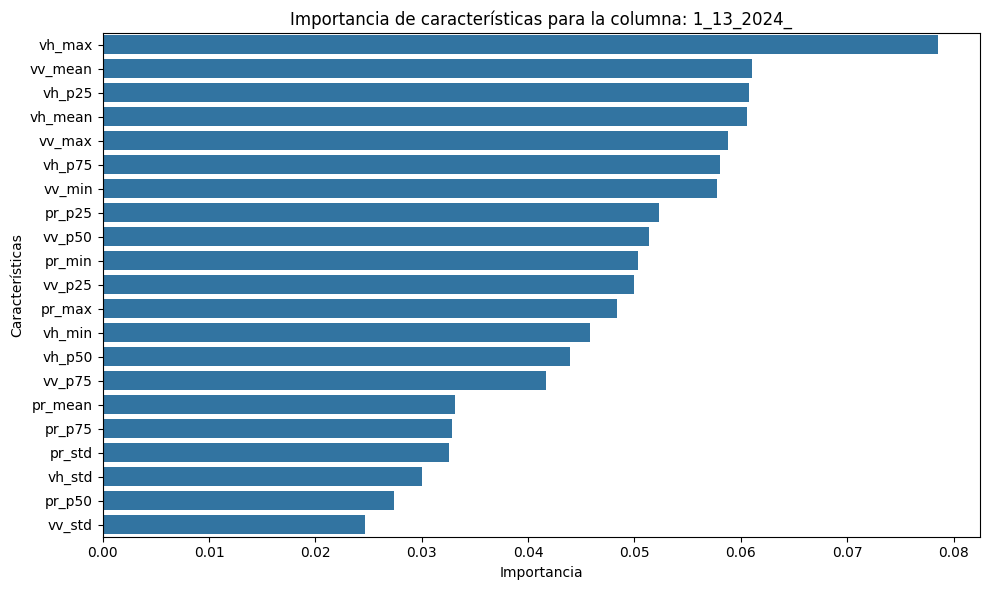

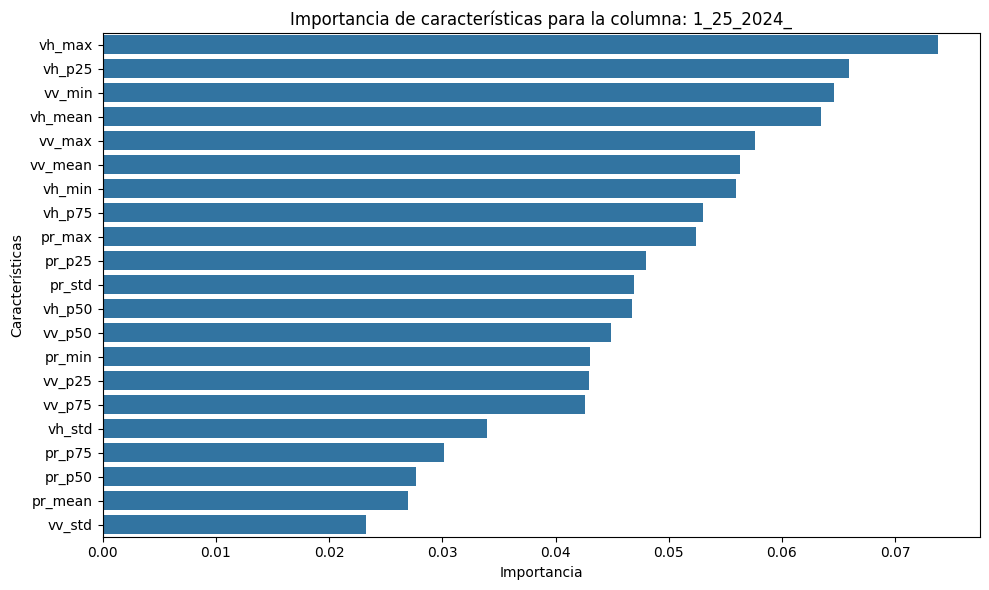

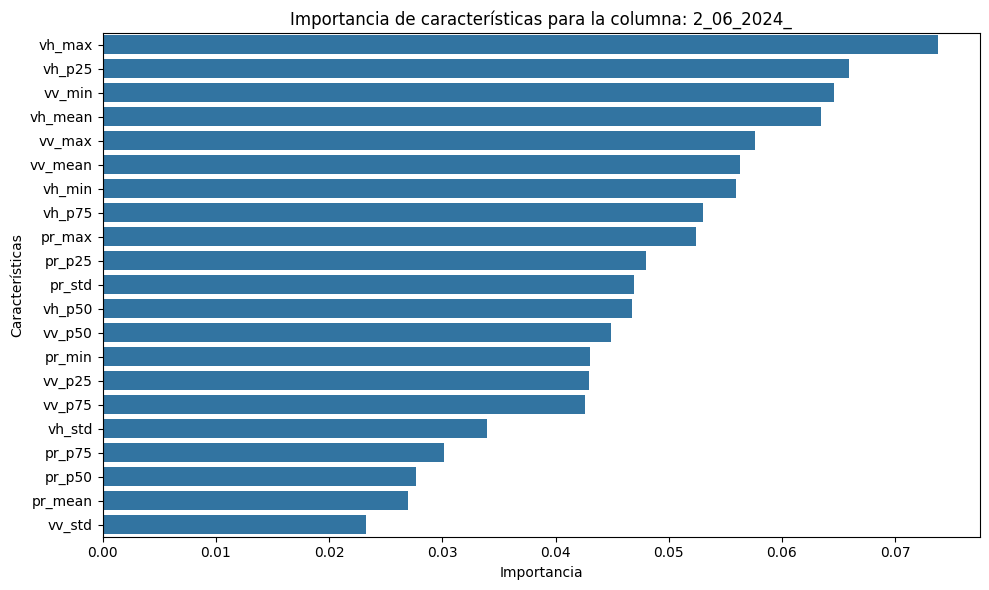

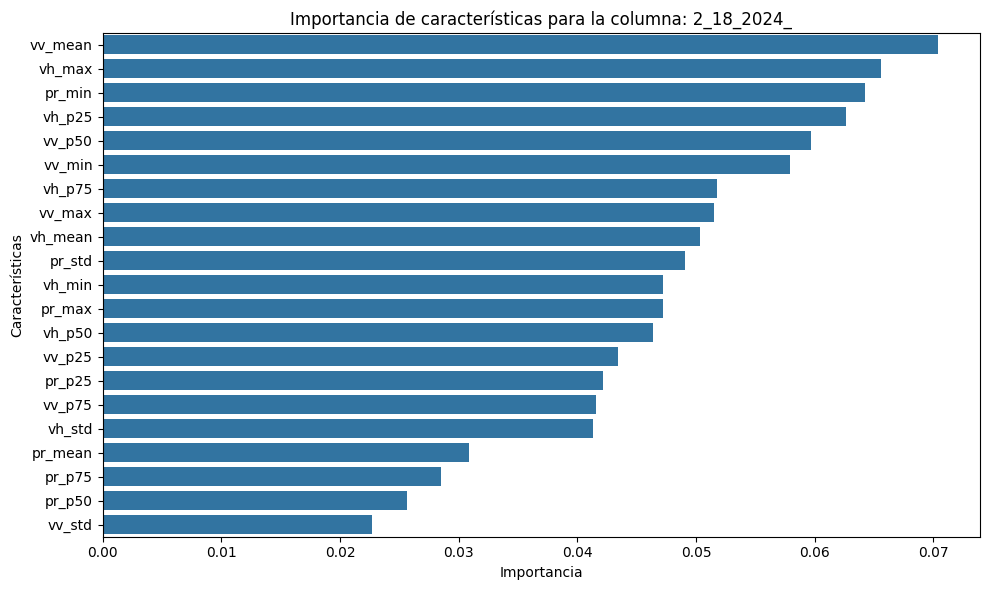

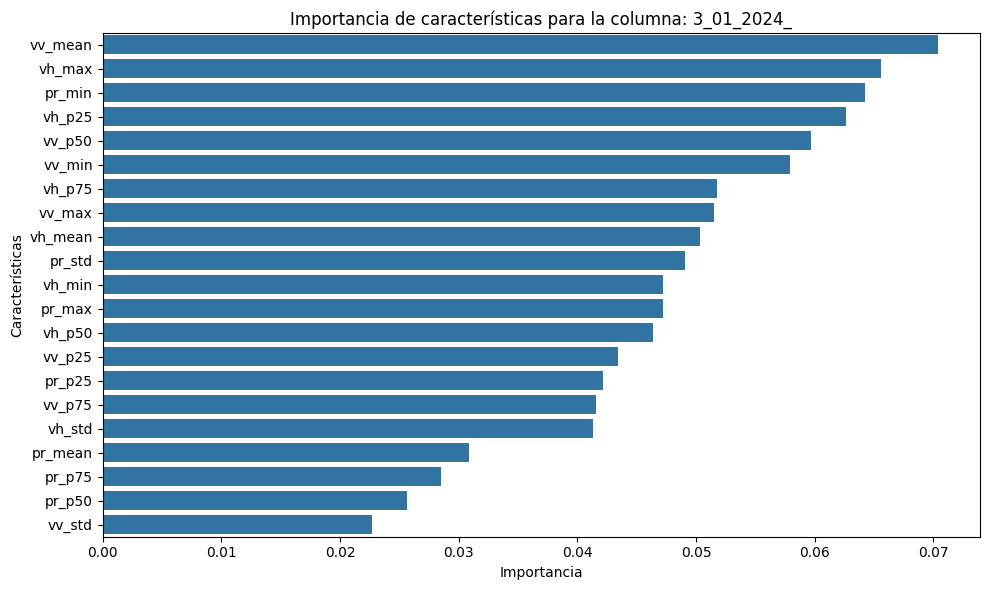

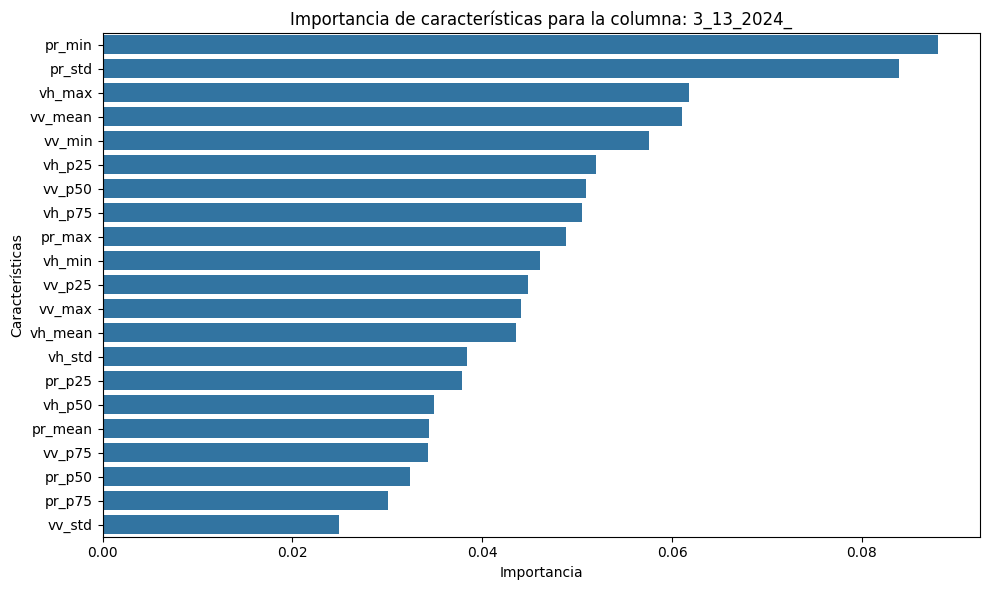

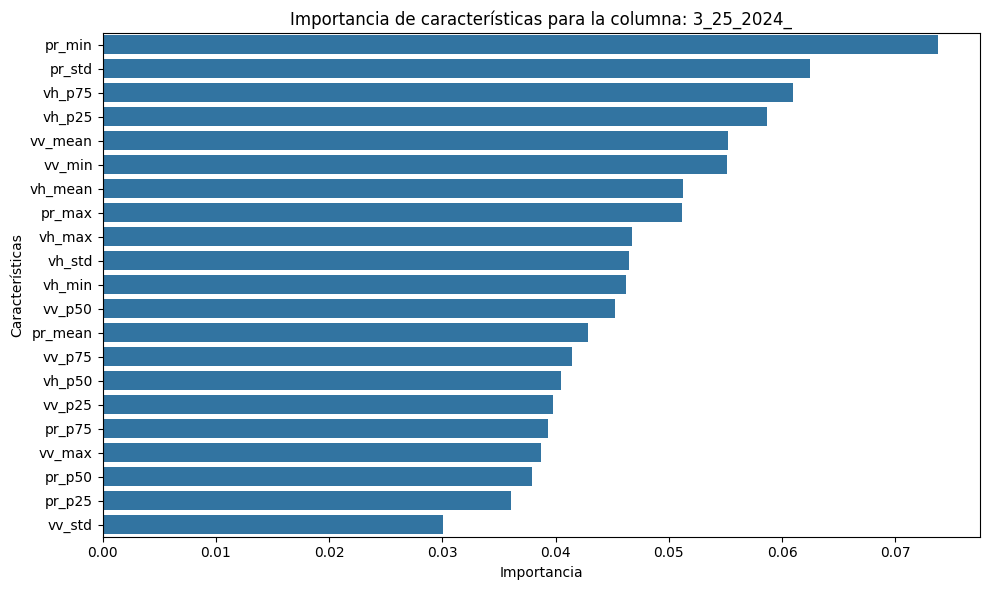

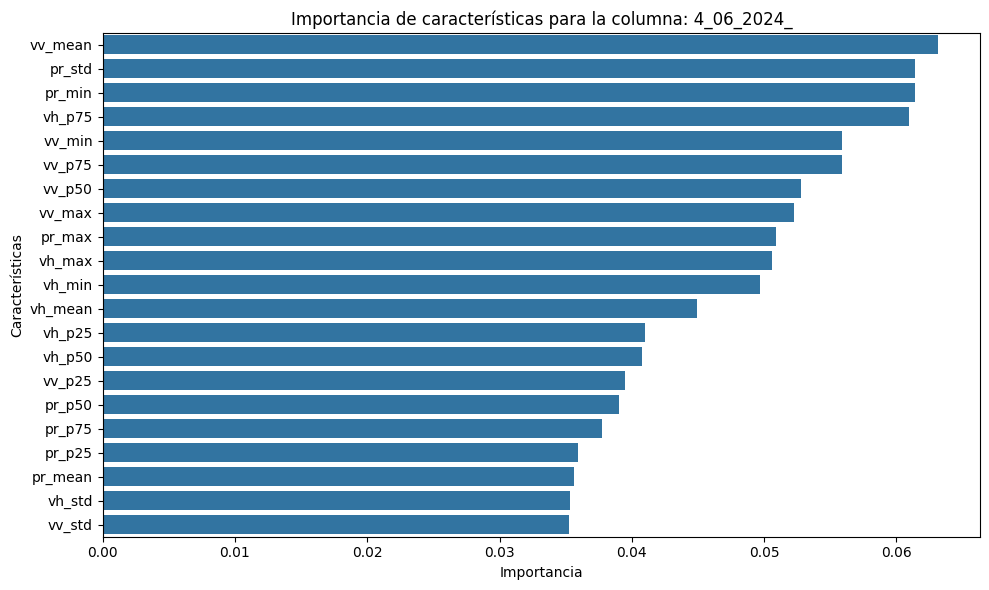

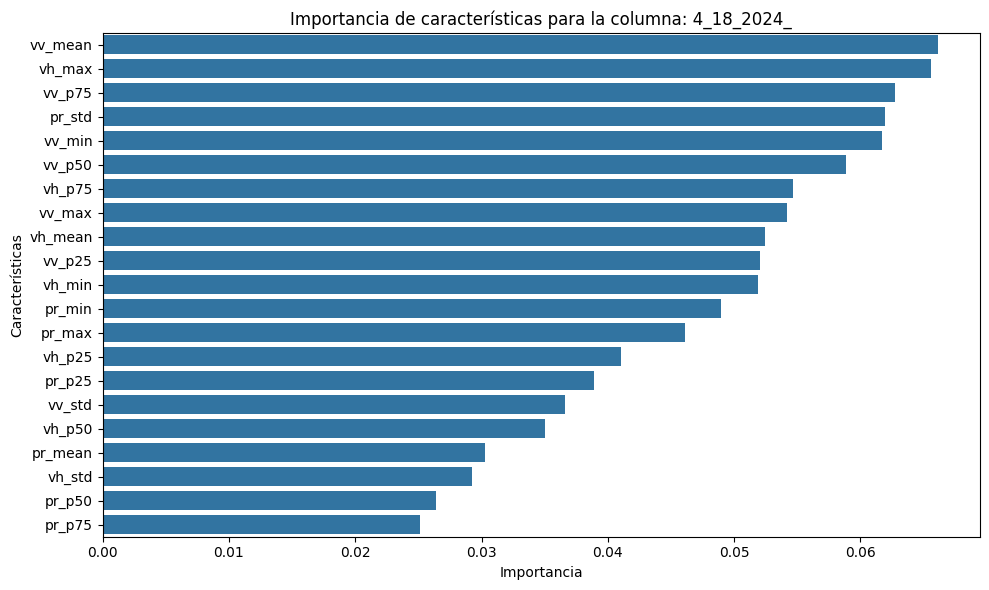

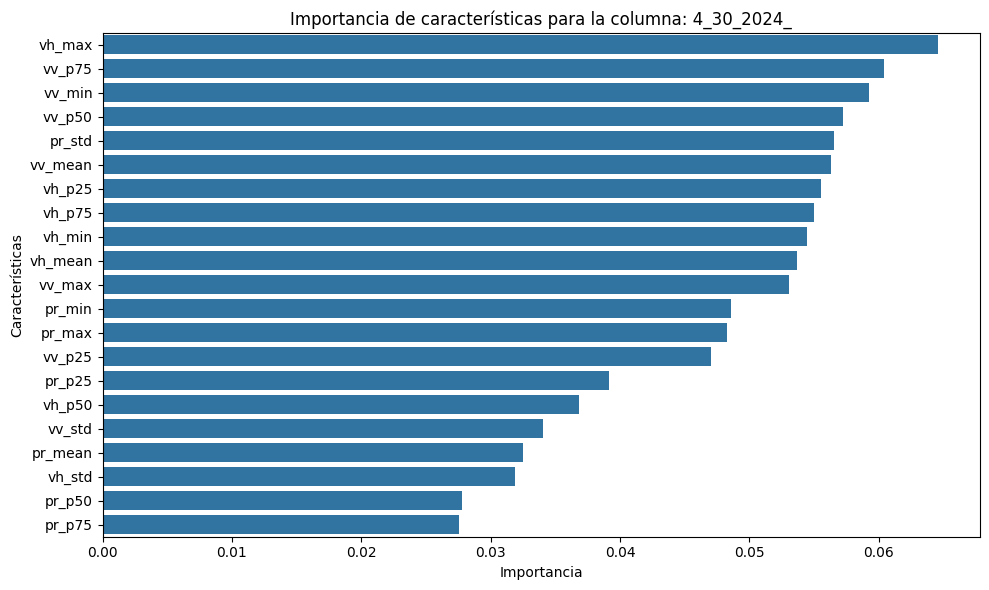

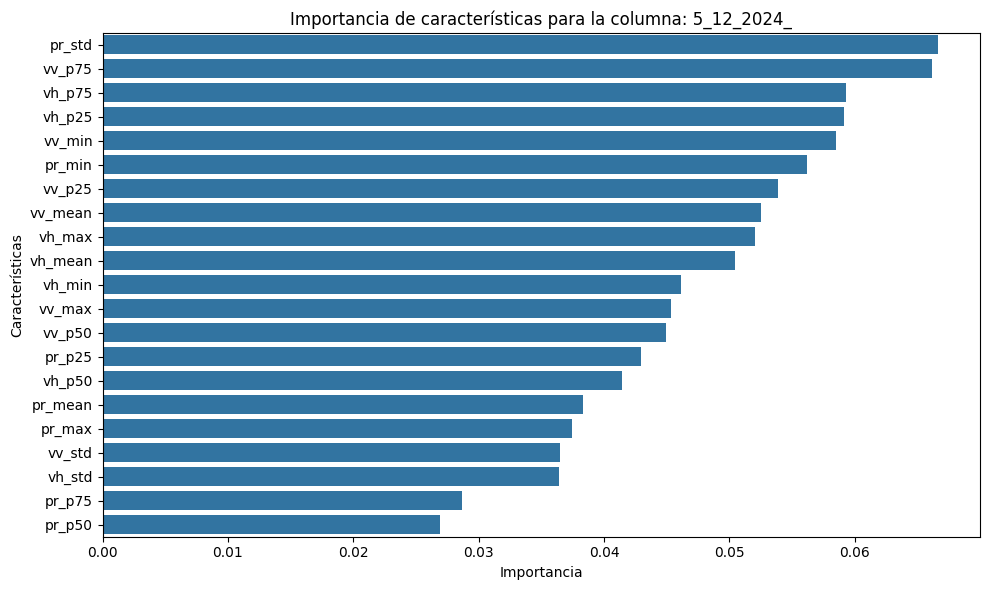

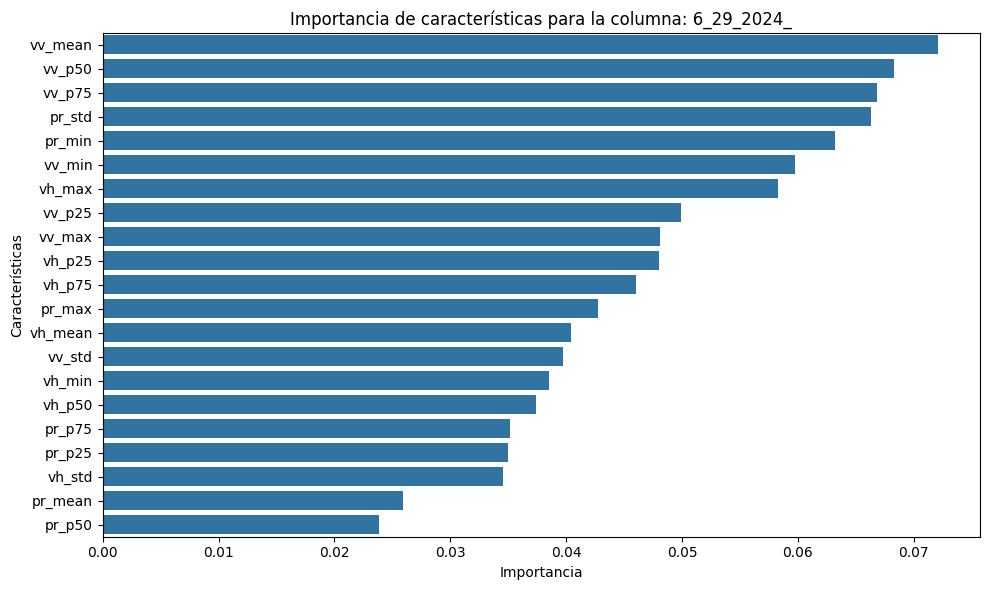

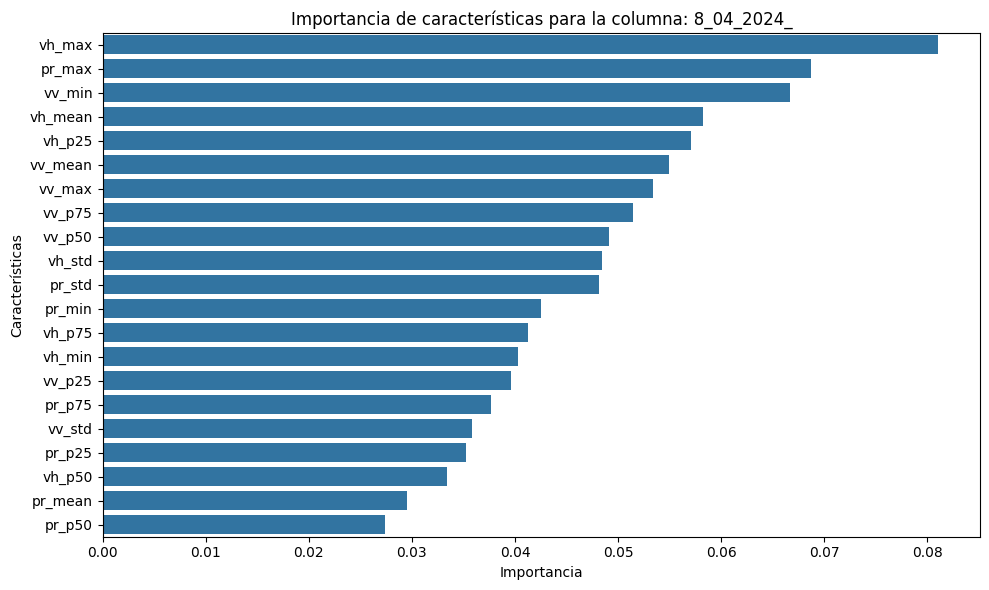

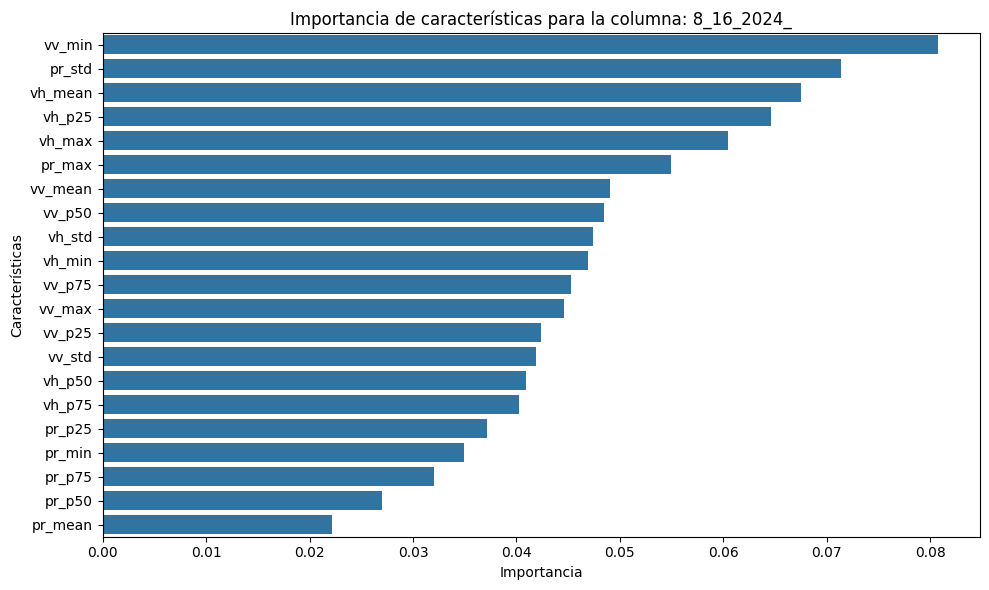

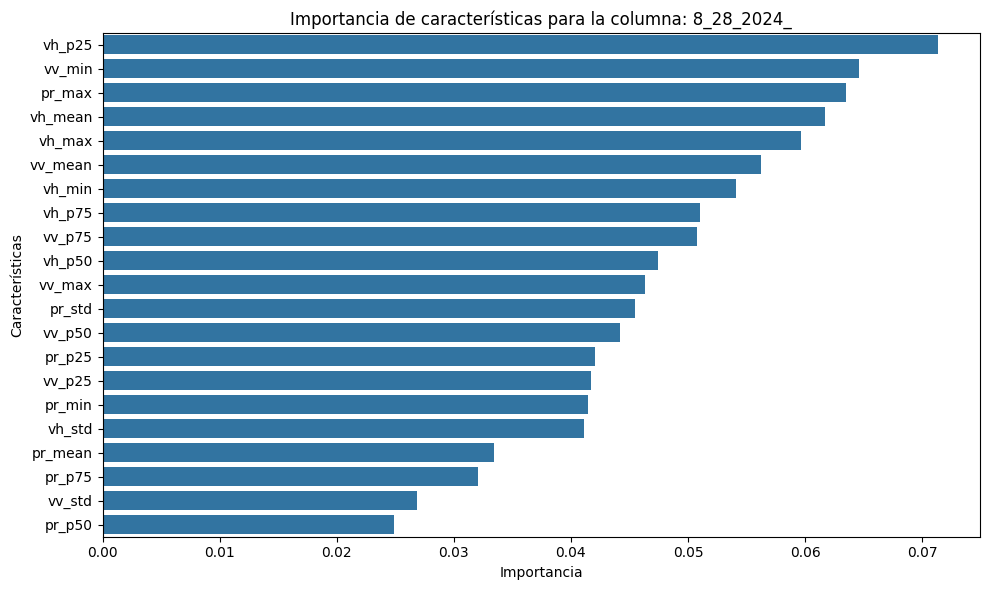

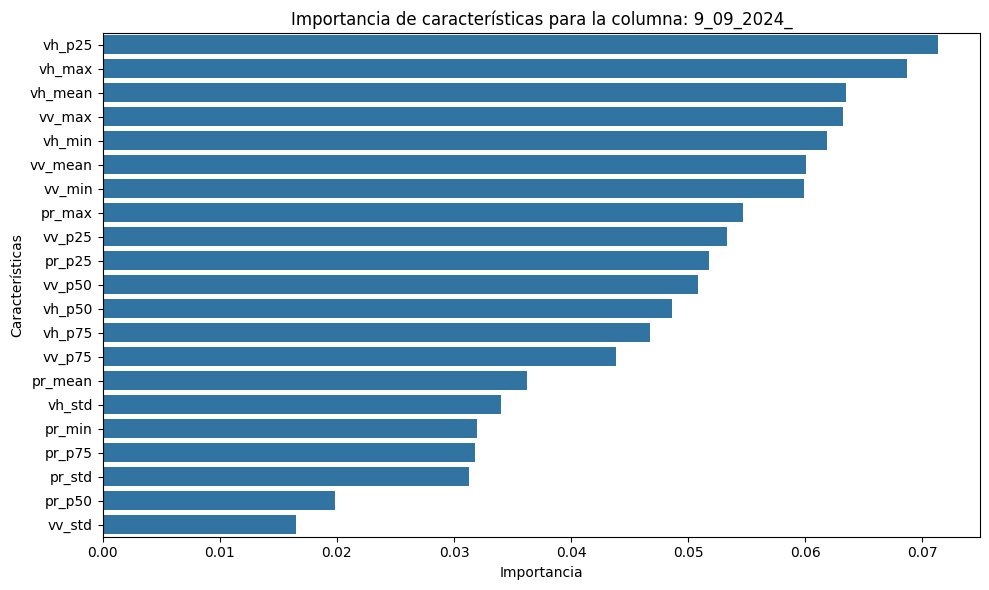

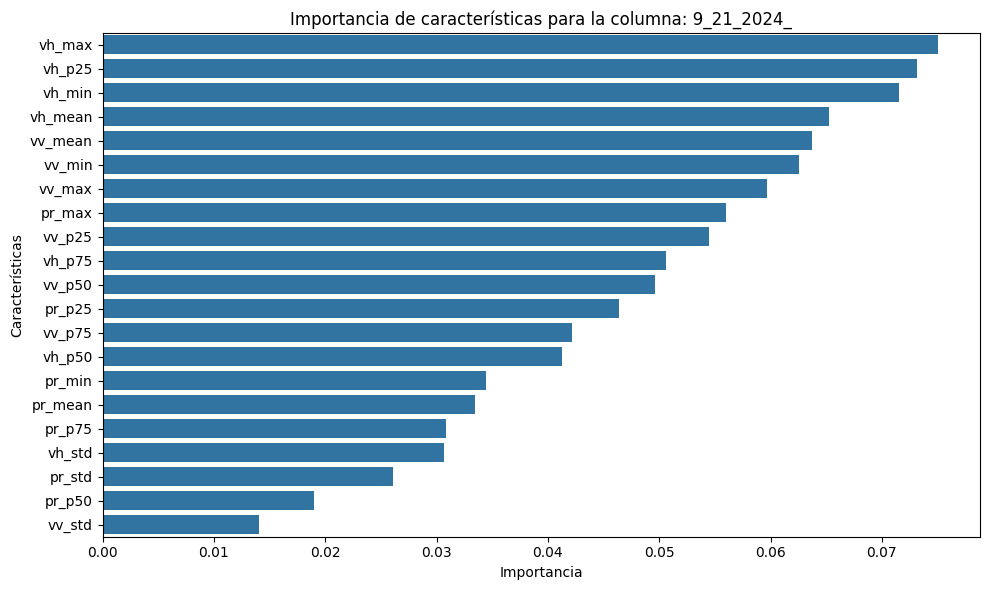

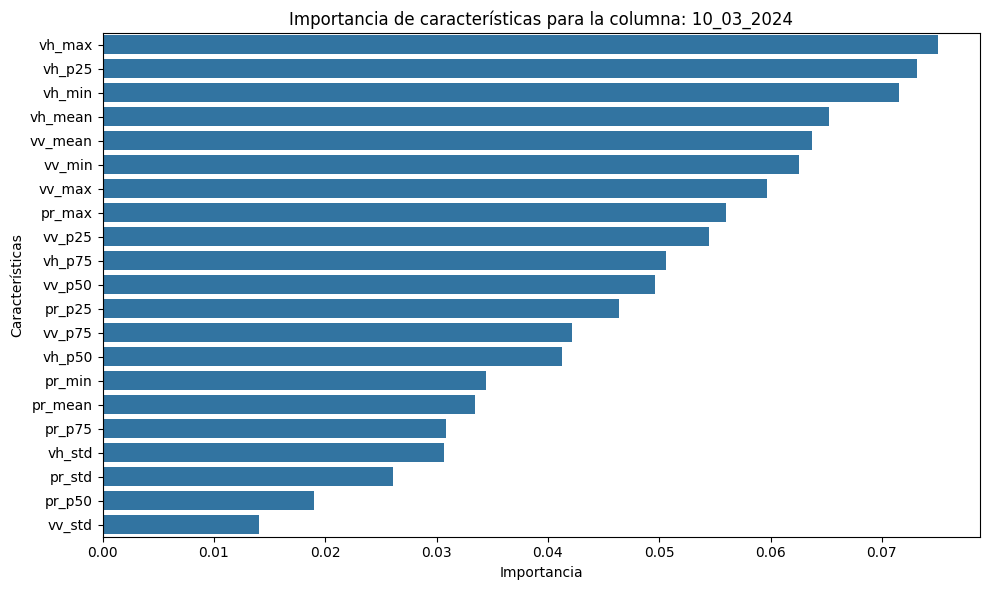

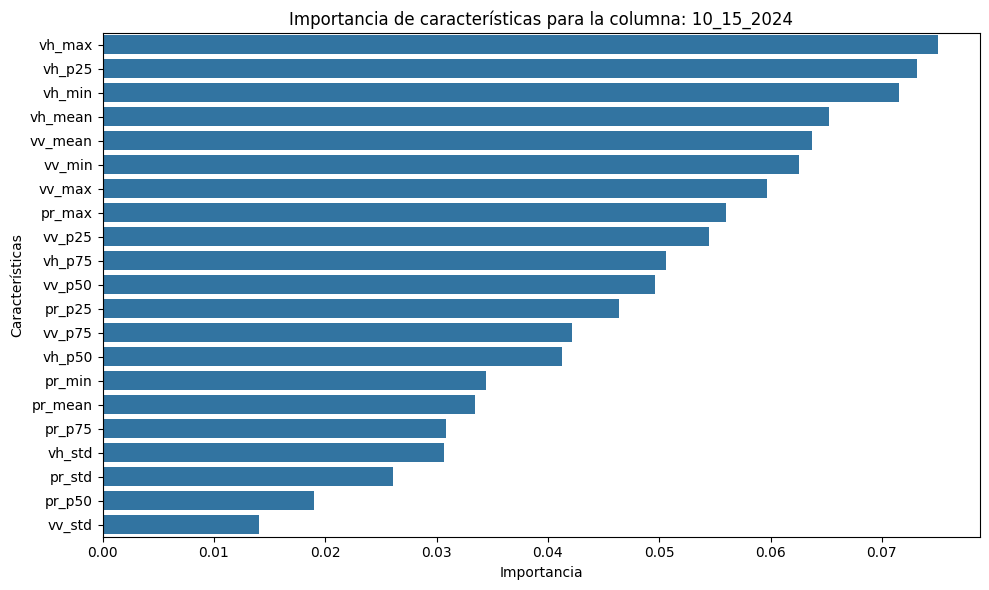

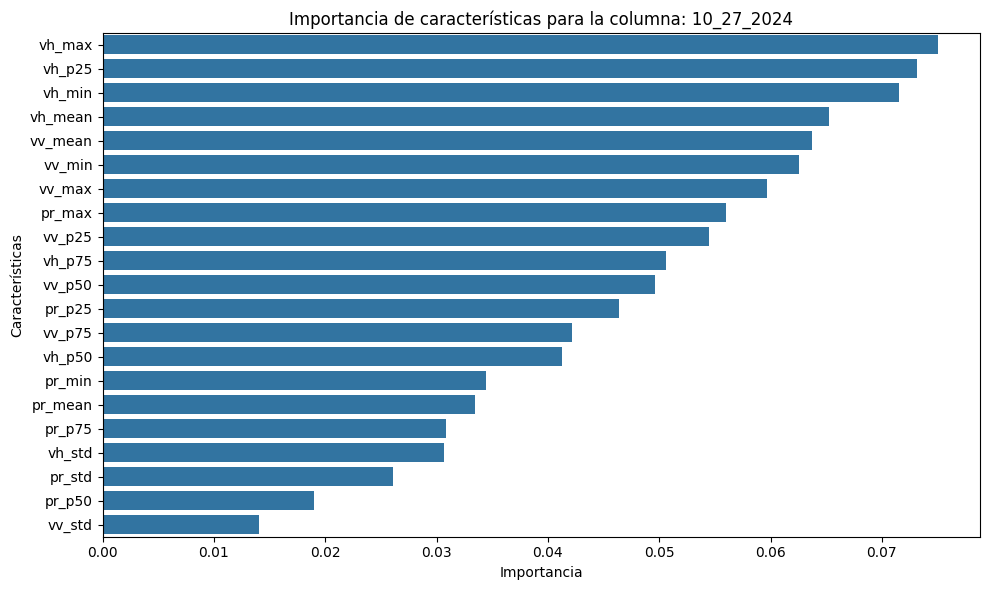

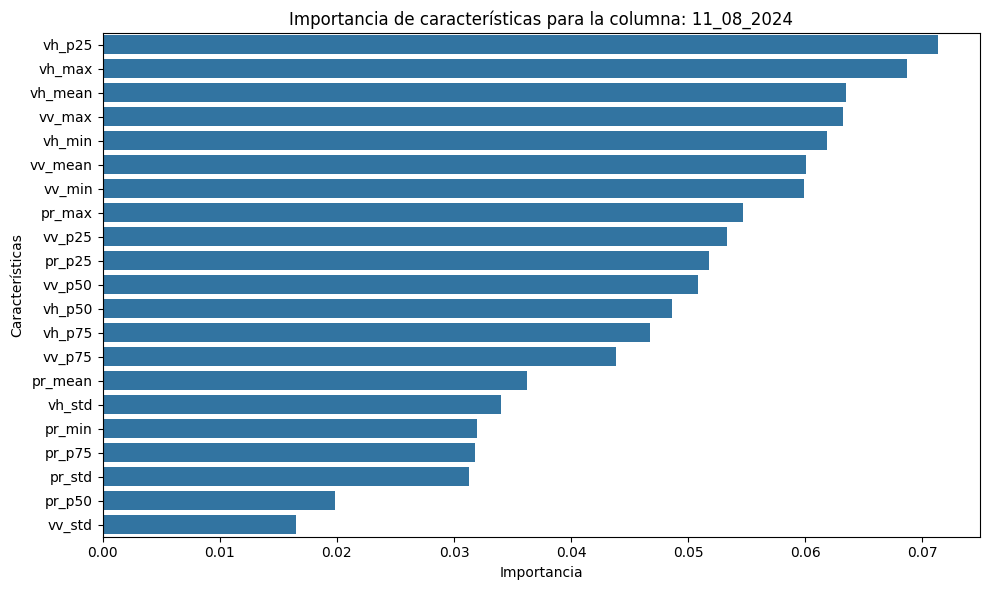

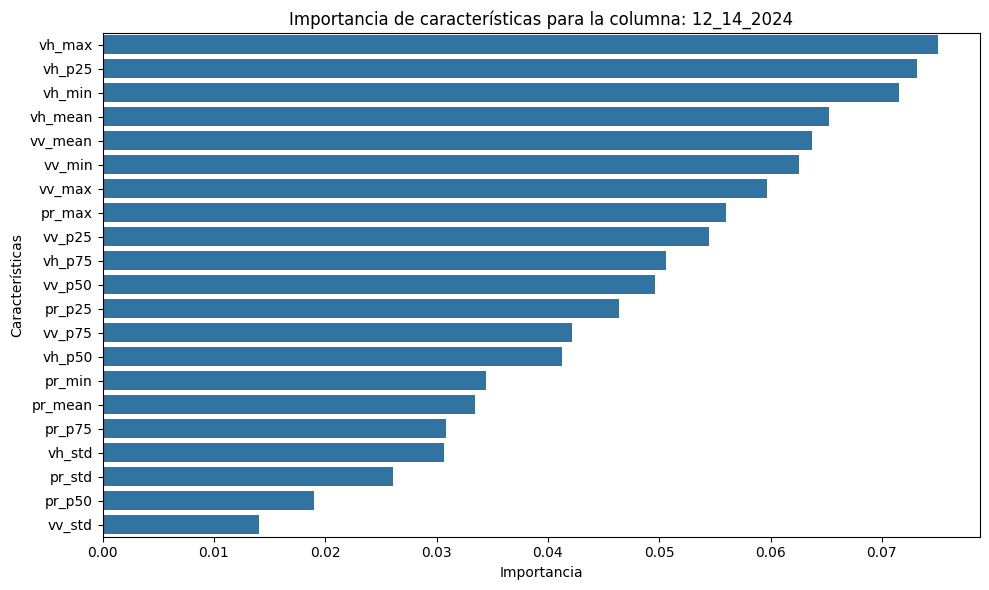

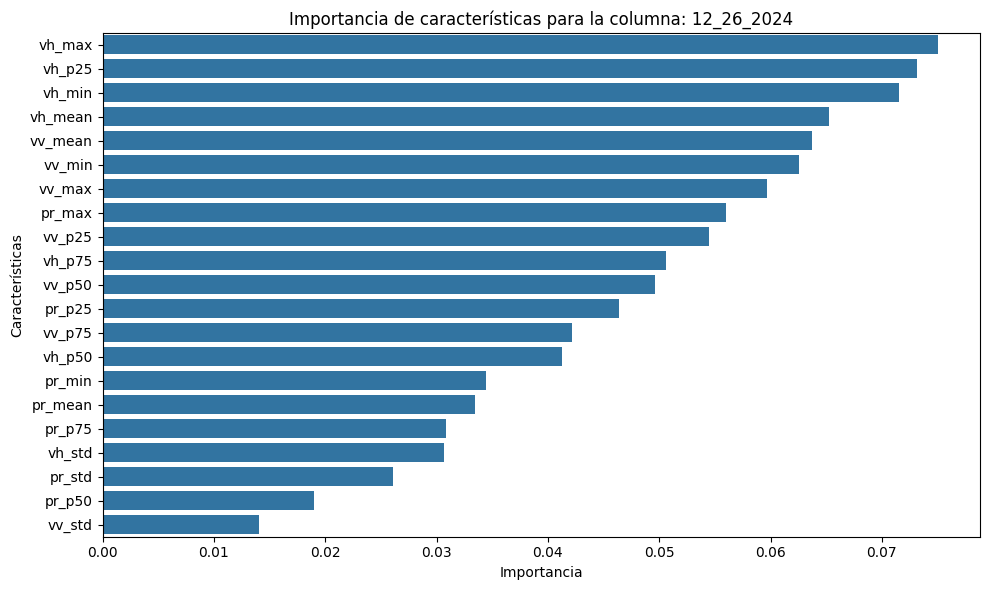

In [ ]:
# Extraer el mejor modelo MultiOutputClassifier
best_model = grid_search.best_estimator_

# Definir nombres de características
feature_names = [f'vh_{stat}' for stat in ['mean','std','min','max','p25','p50','p75']] + \
                [f'vv_{stat}' for stat in ['mean','std','min','max','p25','p50','p75']] + \
                [f'pr_{stat}' for stat in ['mean','std','min','max','p25','p50','p75']]

# Visualizar importancias por cada etiqueta
for i, col in enumerate(label_columns):
    rf_model = best_model.estimators_[i]  # Acceder al modelo individual
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Graficar
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=np.array(feature_names)[indices])
    plt.title(f"Importancia de características para la columna: {col}")
    plt.xlabel("Importancia")
    plt.ylabel("Características")
    plt.tight_layout()
    plt.show()

# Start predictions using Random Forest Model

PR index (VH - VV) computation complete.


In [ ]:
import numpy as np
import rasterio
import os
import joblib

# Rutas
vv_path = "/content/WETSAT_v2/0_Original_Files/aoi1/aoi1/sigma_dB/VV_sigma_dB"
vh_path = "/content/WETSAT_v2/0_Original_Files/aoi1/aoi1/sigma_dB/VH_sigma_dB"
pr_path = "/content/WETSAT_v2/0_Original_Files/aoi1/aoi1/sigma_dB/PR_index"
output_path = "/content/predictions"
os.makedirs(output_path, exist_ok=True)

# Cargar modelo y codificadores
model = joblib.load("models/random_forest_model.pkl")
encoders = joblib.load("encoders.pkl")
label_encoder = list(encoders.values())[0]  # Usamos el primero como referencia

# Listar archivos
vv_files = sorted([f for f in os.listdir(vv_path) if f.endswith(".tif")])
vh_files = sorted([f for f in os.listdir(vh_path) if f.endswith(".tif")])
pr_files = sorted([f for f in os.listdir(pr_path) if f.endswith(".tif")])

assert len(vv_files) == len(vh_files) == len(pr_files), "Cantidad desigual de imágenes VV, VH y PR"

# Función para calcular estadísticas por pixel
def compute_stats_per_pixel(vv, vh, pr):
    stack = np.stack([vv, vh, pr], axis=0)  # shape: (3, height, width)
    stats = np.stack([
        np.nanmean(stack, axis=0),
        np.nanstd(stack, axis=0),
        np.nanmin(stack, axis=0),
        np.nanmax(stack, axis=0),
        np.nanpercentile(stack, 25, axis=0),
        np.nanpercentile(stack, 50, axis=0),
        np.nanpercentile(stack, 75, axis=0)
    ], axis=-1)  # shape: (height, width, 7)
    return stats  # 7 estadísticas por pixel

# Iterar sobre cada conjunto
for i, (vv_file, vh_file, pr_file) in enumerate(zip(vv_files, vh_files, pr_files)):
    with rasterio.open(os.path.join(vv_path, vv_file)) as vv_src, \
         rasterio.open(os.path.join(vh_path, vh_file)) as vh_src, \
         rasterio.open(os.path.join(pr_path, pr_file)) as pr_src:

        vv = vv_src.read(1).astype("float32")
        vh = vh_src.read(1).astype("float32")
        pr = pr_src.read(1).astype("float32")
        profile = vv_src.profile
        height, width = vv.shape

    # Calcular estadísticas por pixel
    stats = compute_stats_per_pixel(vv, vh, pr)  # shape: (height, width, 7)

    # Expandir a 21 características (7 por cada banda)
    vv_stats = compute_stats_per_pixel(vv, vv, vv)
    vh_stats = compute_stats_per_pixel(vh, vh, vh)
    pr_stats = compute_stats_per_pixel(pr, pr, pr)
    X_pixel = np.concatenate([vv_stats, vh_stats, pr_stats], axis=-1)  # shape: (height, width, 21)

    # Preparar para predicción
    X_flat = X_pixel.reshape(-1, 21)
    X_flat = np.nan_to_num(X_flat, nan=0.0, posinf=0.0, neginf=0.0)

    # Predecir etiquetas
    y_pred = model.predict(X_flat)  # shape: (n_pixels, n_labels)
    y_pred_majority = np.apply_along_axis(lambda row: np.bincount(row).argmax(), axis=1, arr=y_pred)
    label_img = y_pred_majority.reshape(height, width)

    # Guardar imagen
    profile.update(dtype="uint8", count=1, nodata=0)
    output_file = os.path.join(output_path, f"{i+1}.tif")
    with rasterio.open(output_file, "w", **profile) as dst:
        dst.write(label_img.astype("uint8"), 1)

    print(f"✅ Imagen {i+1} guardada como pronóstico: {output_file}")

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


✅ Imagen 1 guardada como pronóstico: /content/predictions/1.tif


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


✅ Imagen 2 guardada como pronóstico: /content/predictions/2.tif


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


✅ Imagen 3 guardada como pronóstico: /content/predictions/3.tif


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


✅ Imagen 4 guardada como pronóstico: /content/predictions/4.tif


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


✅ Imagen 5 guardada como pronóstico: /content/predictions/5.tif


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


✅ Imagen 6 guardada como pronóstico: /content/predictions/6.tif


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


✅ Imagen 7 guardada como pronóstico: /content/predictions/7.tif


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


✅ Imagen 8 guardada como pronóstico: /content/predictions/8.tif


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


✅ Imagen 9 guardada como pronóstico: /content/predictions/9.tif


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


✅ Imagen 10 guardada como pronóstico: /content/predictions/10.tif


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


✅ Imagen 11 guardada como pronóstico: /content/predictions/11.tif


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


KeyboardInterrupt: 

In [ ]:
import json
import os

# Carpeta de salida
legend_path = "/content/predictions"
os.makedirs(legend_path, exist_ok=True)

# Crear diccionario de leyenda por etiqueta
legend = {}
for label_name, encoder in encoders.items():
    legend[label_name] = {int(i): label for i, label in enumerate(encoder.classes_)}

# Guardar como archivo JSON
with open(os.path.join(legend_path, "class_legend.json"), "w") as f:
    json.dump(legend, f, indent=4)

print("📘 Leyenda de clases exportada como class_legend.json")

In [ ]:
# Cargar todos los modelos desde un único archivo
rf_bundle = joblib.load("models/all_rf_models.pkl")
models = rf_bundle["models"]  # Diccionario: {fecha: modelo}

# Crear carpeta de salida
output_dir = "/content/WETSAT_v2/Predictions"
os.makedirs(output_dir, exist_ok=True)

# Generar predicciones por fecha
for i in range(n_fechas):
    vh_band = vh_images[i]
    vv_band = vv_images[i]
    pr_band = pr_images[i]

    rows, cols = vh_band.shape

    # Preparar matriz de predicción
    X_pred = np.column_stack((
        vh_band.flatten(),
        vv_band.flatten(),
        pr_band.flatten()
    ))

    # Obtener modelo correspondiente a la fecha
    label = label_columns[i]
    model = models[label]

    # Predecir y reestructurar como imagen
    y_pred = model.predict(X_pred)
    label_map = y_pred.reshape(rows, cols)

    # Reemplazar NaN y convertir a uint8
    label_map = np.nan_to_num(label_map, nan=0).astype("uint8")

    # Obtener perfil del raster original
    with rasterio.open(os.path.join(vh_path, sorted(os.listdir(vh_path))[i])) as src:
        profile = src.profile
        profile.update(dtype="uint8", count=1, nodata=0)

    # Guardar como GeoTIFF
    output_path = os.path.join(output_dir, f"prediction_{label}.tif")
    with rasterio.open(output_path, "w", **profile) as dst:
        dst.write(label_map, 1)

print("✅ Map predictions stored by date using unified model archive.")

# Visualize Predictions Maps

In [ ]:
# Visualizar cada mapa de predicción por fecha
for label in label_columns:
    map_path = os.path.join(output_dir, f"prediction_{label}.tif")

    if os.path.exists(map_path):
        with rasterio.open(map_path) as src:
            pred_map = src.read(1)
            bounds = src.bounds
            crs = src.crs

        plt.figure(figsize=(8, 6))
        plt.imshow(pred_map, cmap="viridis")
        plt.title(f"🗺️ Predicción: {label}", fontsize=14)
        plt.colorbar(label="Clase predicha")
        plt.axis("off")
        plt.tight_layout()
        plt.show()
    else:
        print(f"⚠️ Mapa no encontrado para la fecha: {label}")

In [ ]:
# Crear un mapa de colores único por etiqueta
def create_label_colormap(encoder):
    classes = encoder.classes_
    palette = sns.color_palette("hsv", len(classes))
    color_dict = dict(zip(classes, palette))
    return color_dict

for label in label_columns:
    map_path = os.path.join(output_dir, f"prediction_{label}.tif")

    if os.path.exists(map_path):
        with rasterio.open(map_path) as src:
            pred_map = src.read(1)
            rows, cols = pred_map.shape

        # Obtener encoder y transformar a etiquetas originales
        encoder = encoders[label]
        pred_labels = encoder.inverse_transform(pred_map.flatten())
        label_map = pred_labels.reshape(rows, cols)

        # Crear colormap personalizado
        color_dict = create_label_colormap(encoder)
        unique_labels = np.unique(label_map)
        label_to_int = {label: i for i, label in enumerate(unique_labels)}
        int_map = np.vectorize(label_to_int.get)(label_map)
        cmap = sns.color_palette([color_dict[l] for l in unique_labels])

        # Graficar
        plt.figure(figsize=(8, 6))
        plt.imshow(int_map, cmap=plt.cm.get_cmap("tab20", len(unique_labels)))
        cbar = plt.colorbar(ticks=range(len(unique_labels)))
        cbar.ax.set_yticklabels(unique_labels)
        plt.title(f"🗺️ Predicción con etiquetas: {label}", fontsize=14)
        plt.axis("off")
        plt.tight_layout()
        plt.show()
    else:
        print(f"⚠️ Mapa no encontrado para la fecha: {label}")